In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [7]:
'''
getting some data
'''
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
dataset_fname = 'bursi.pos.gspan'
def get_graphs(size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

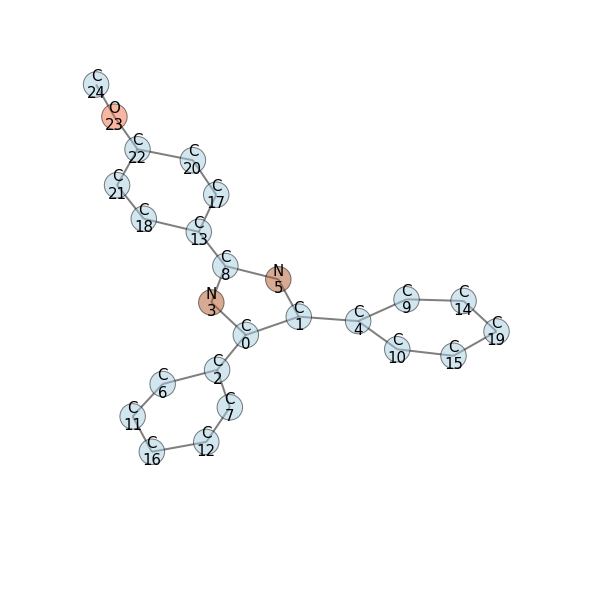

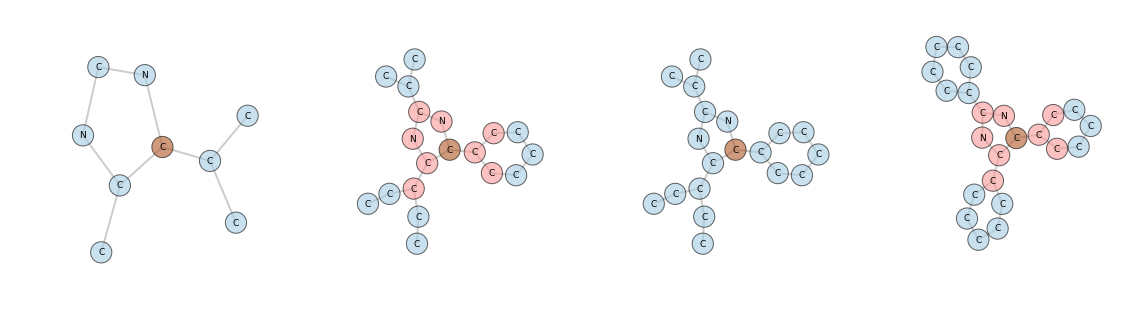

In [9]:
'''
first we test the core/interface extractor, since it is most essential
'''
from graphlearn.utils.draw import display, cip_to_graph, draw_graph_set_graphlearn
from graphlearn.graphtools import extract_core_and_interface

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = get_graphs()
graph=graphs.next()
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','O','N','P','Cl','Br','S'])    
graph=graphs.next()

display(graph, size=10, secondary_vertex_label='ID',
        colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
        vertex_alpha=0.5, node_size=650)

radius_list=[0,2]
thickness_list=[2,4]
cip=extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
graph=cip_to_graph(cip)
draw_graph_set_graphlearn(graph,
                          n_graphs_per_line=7, size=5, 
                          colormap='Paired', invert_colormap=False,node_border=1,
                          vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

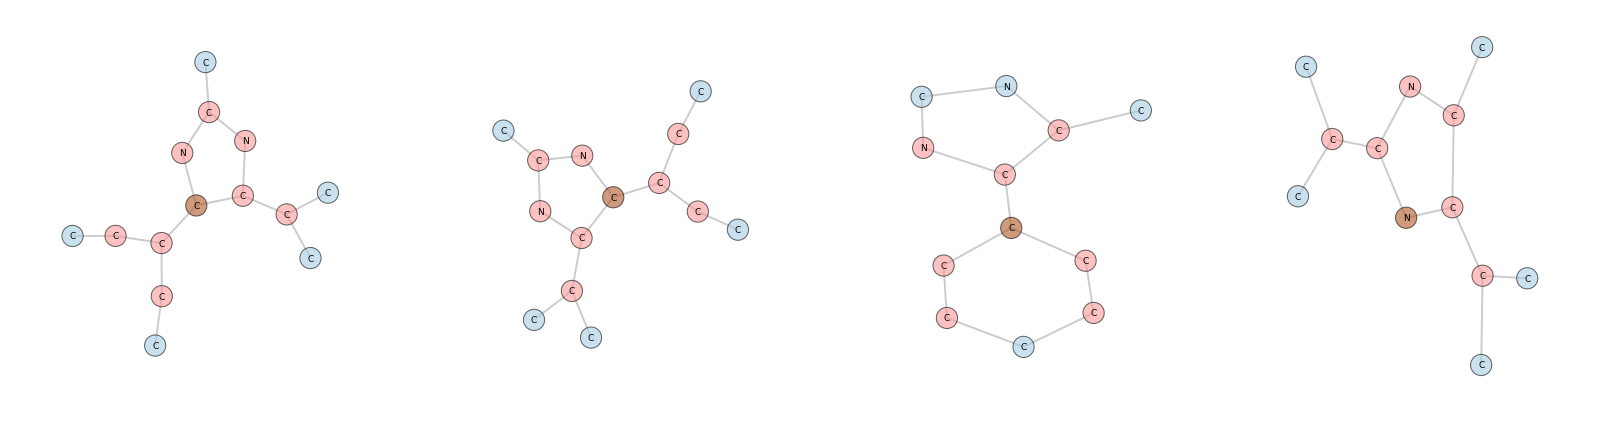

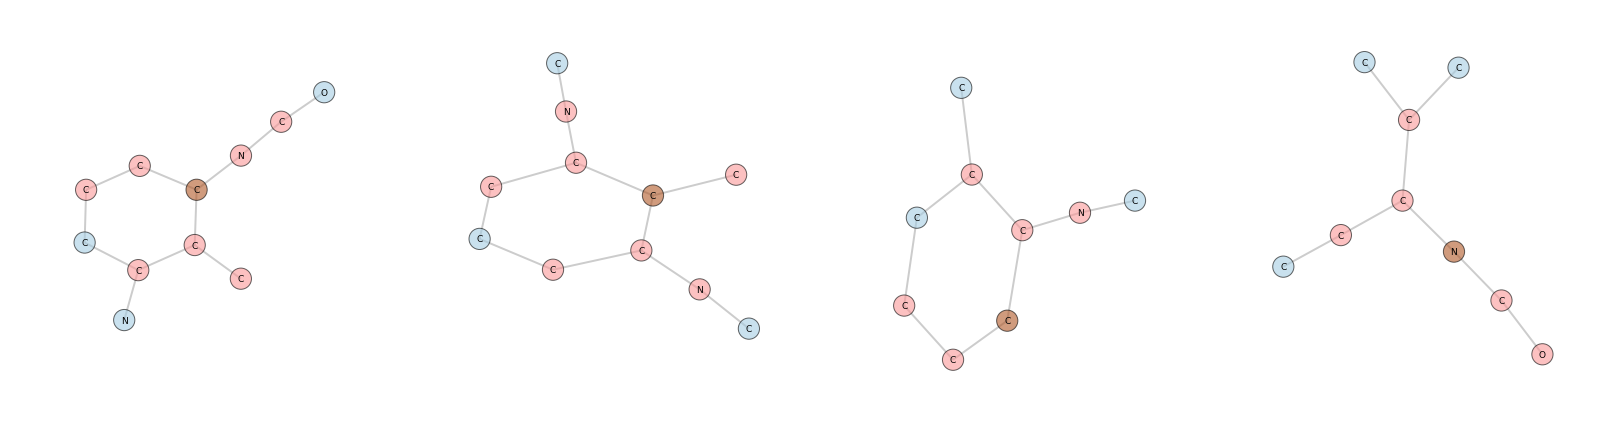

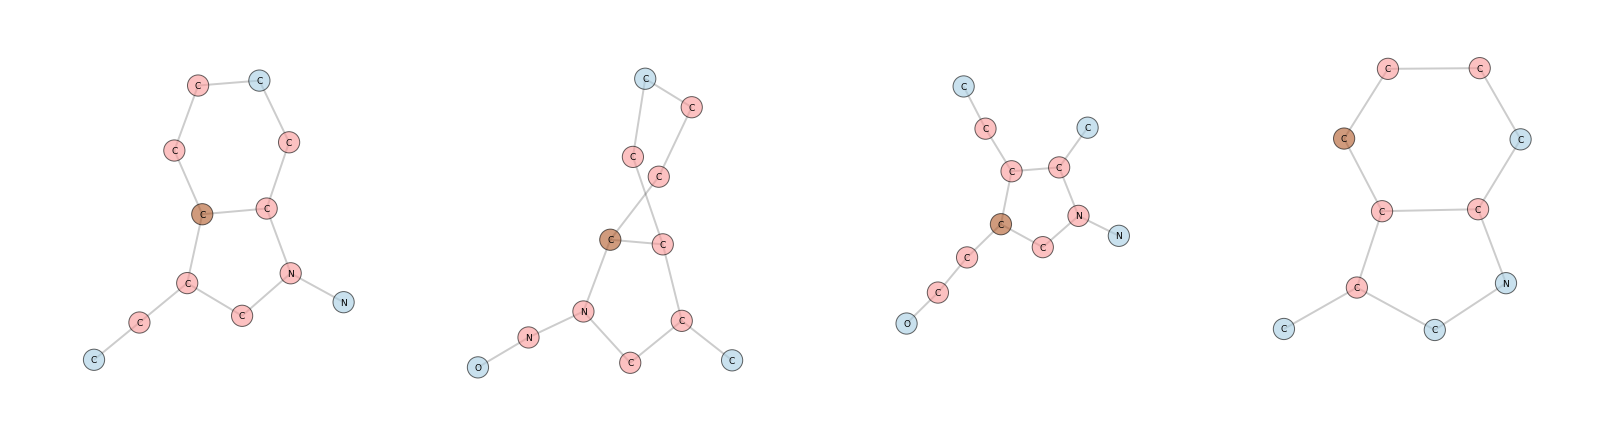

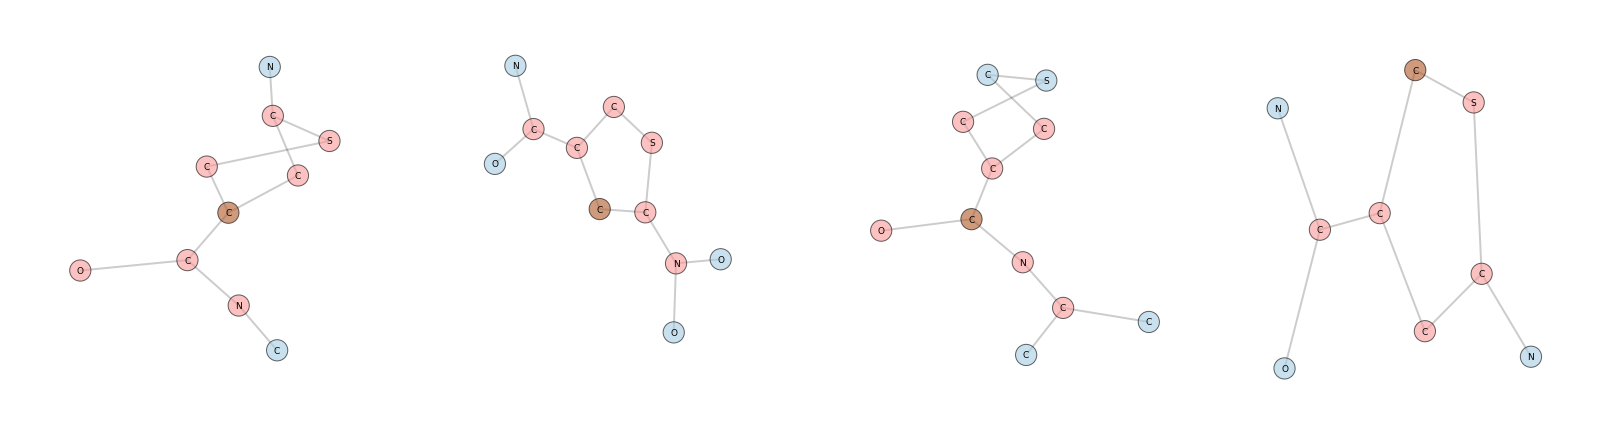

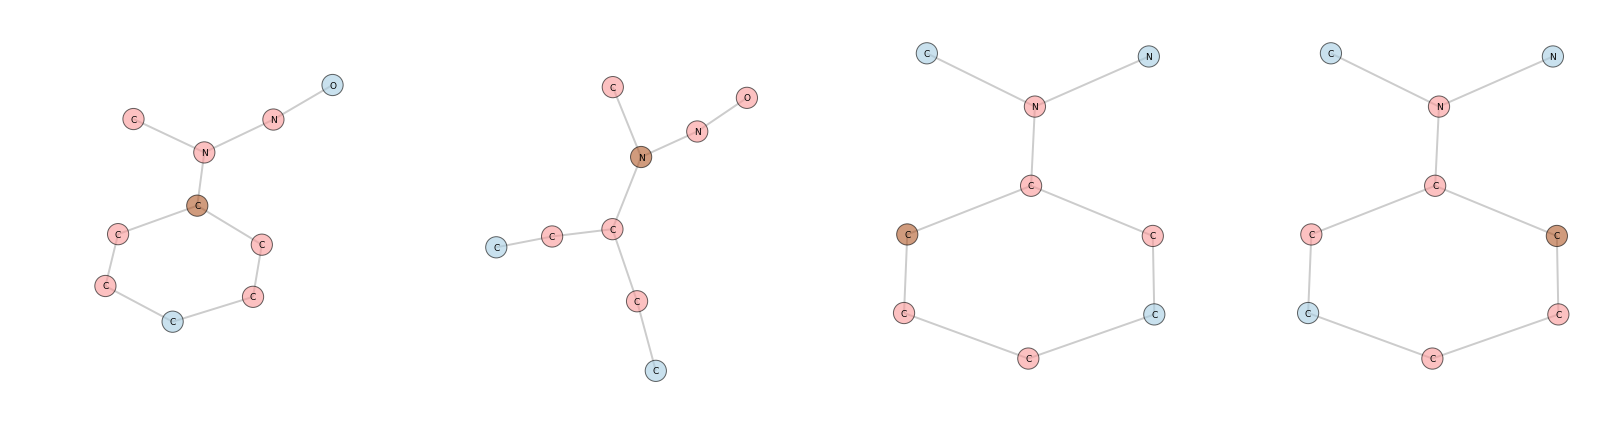

In [18]:
'''
demonstrating more extract core
'''
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.utils.draw import draw_graph_set_graphlearn, cip_to_graph
from graphlearn.graphtools import extract_core_and_interface
from eden.graph import Vectorizer

graphs = get_graphs(size=5)
for graph in graphs:
    graphs_list=[]
    for node in range(4):
        cips = extract_core_and_interface(node,graph,radius_list=[2],thickness_list=[1],vectorizer=Vectorizer())
        # draw cip on the original graph and save in nice_graphs
        cip_graphs = cip_to_graph(cips)
        for g,c in zip(cip_graphs,cips):
            g.graph['info'] = str(c.interface_hash)
        graphs_list += cip_graphs
    # draw marked graphs
    draw_graph_set_graphlearn(graphs_list, contract=False,
                              n_graphs_per_line=5, size=7, colormap='Paired', invert_colormap=False,node_border=1,
                              vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

In [20]:
%%time
'''
induce a grammar and train an estimator
'''
from graphlearn.graphlearn import GraphLearnSampler
training_graphs = get_graphs(size=500)
sampler=GraphLearnSampler(radius_list=[0,1],thickness_list=[1],min_cip_count=2, min_interface_count=2)
sampler.fit(training_graphs,n_jobs=-1,batch_size=10)


Classifier:
SGDClassifier(alpha=0.000449667290699, average=False, class_weight=None,
       epsilon=0.1, eta0=0.556771954851, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=47, n_jobs=1,
       penalty='l1', power_t=0.347874153861, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
CPU times: user 22.1 s, sys: 2.46 s, total: 24.5 s
Wall time: 29.2 s


interface: 713463


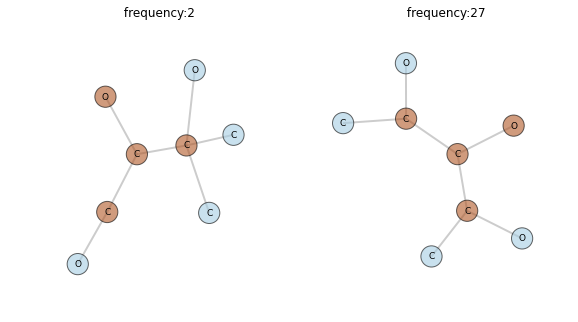

interface: 338607


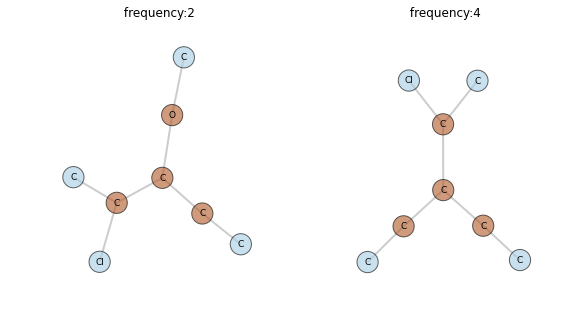

interface: 331823


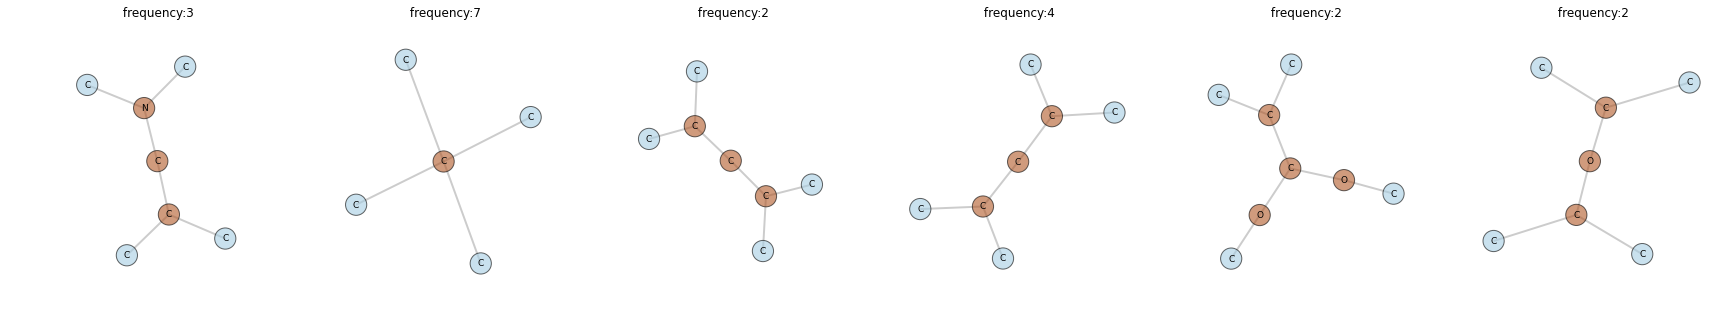

interface: 129077


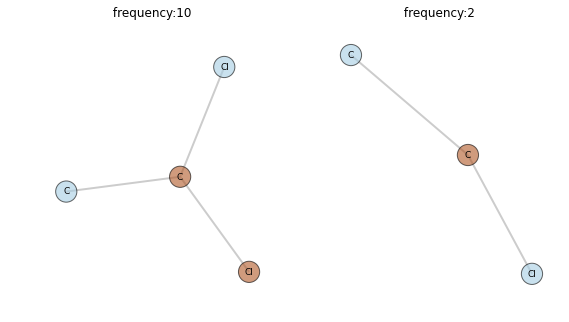

interface: 716865


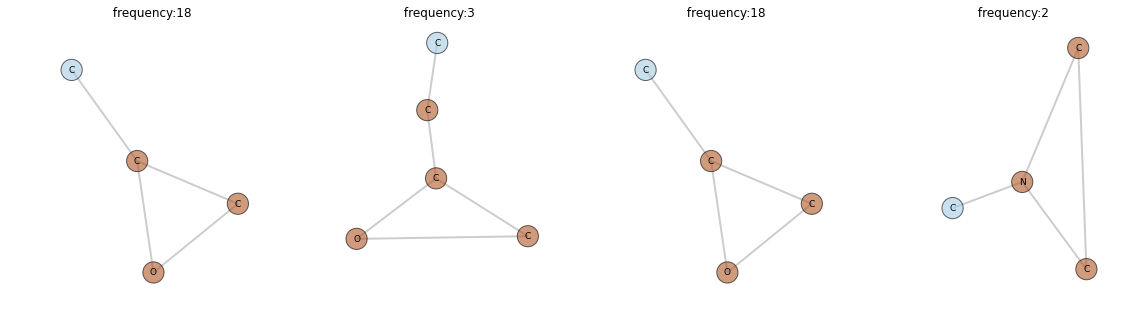

interface: 858468


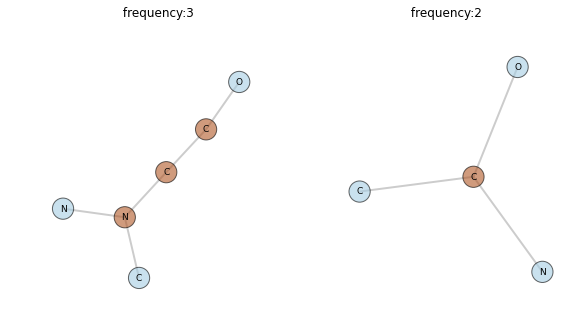

In [23]:
#draw production rules
from graphlearn.utils.draw import draw_grammar
draw_grammar(sampler.get_grammar(),
             n_productions=6,n_graphs_per_line=6, 
             size=5, colormap='Paired', invert_colormap=False,node_border=1,vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

how often do we see interfacehashes
# productions: 606
x = # interfaces (total: 115)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


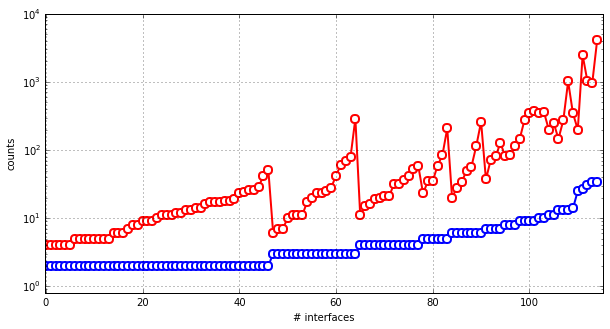

how often was this corehash seen?
x = # cores (total: 100)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


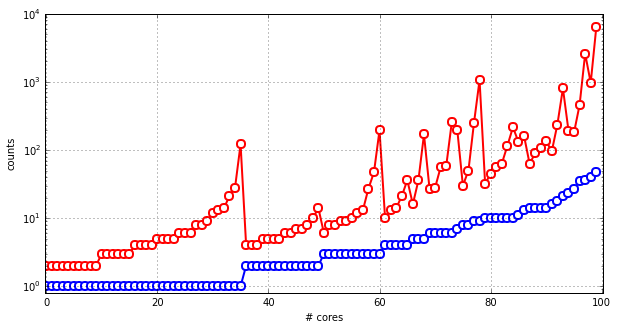

histogram
# productions: 606
distinct cores: 100 (seen on x axis)
interfaces with x many cores were observed y many times. 


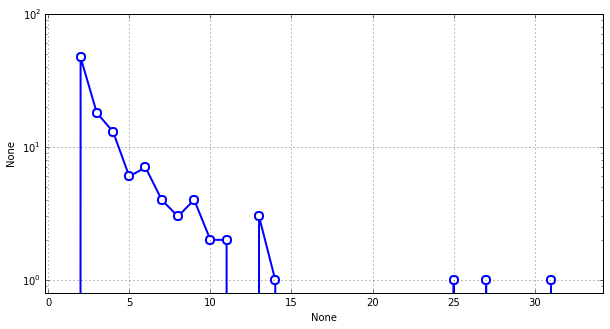

other histogram
how many cores exist with x many interfaces


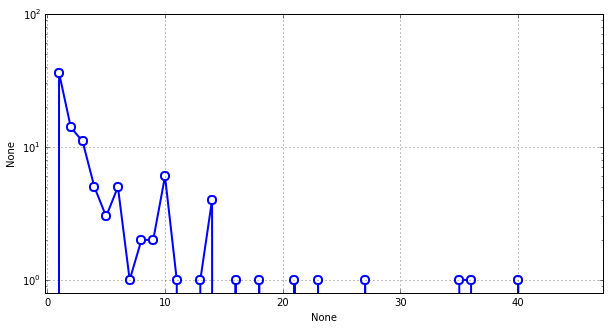

In [24]:
#grammar statistics
from graphlearn.utils.draw import draw_grammar_stats
draw_grammar_stats(sampler.get_grammar(), size=(10,5))

We work on this graph


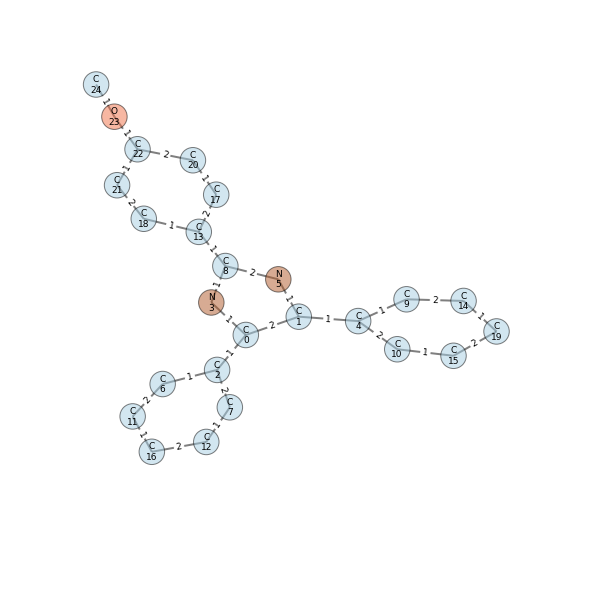

no filter


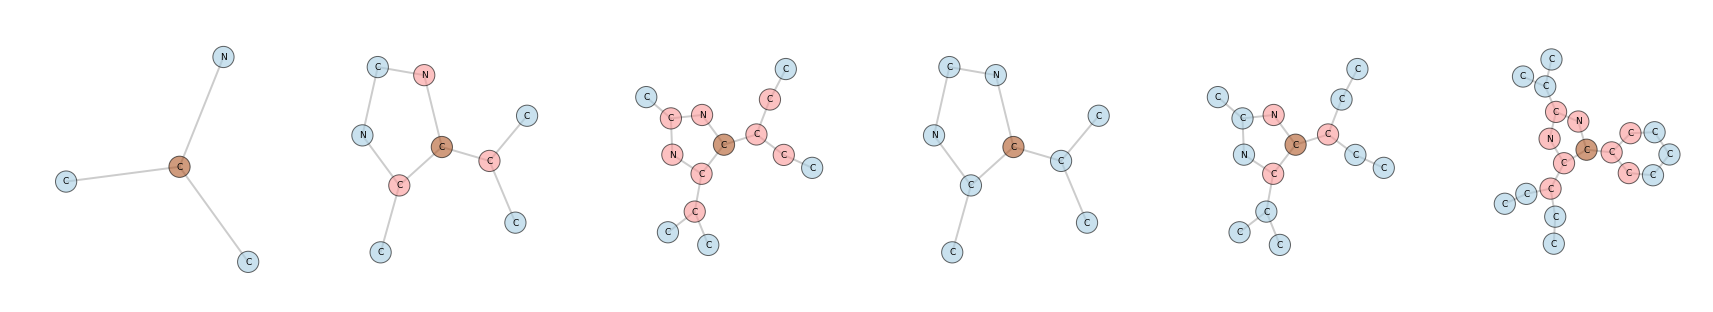

with filter: nothing should appear,,,
with filter but we chose node 2 as root


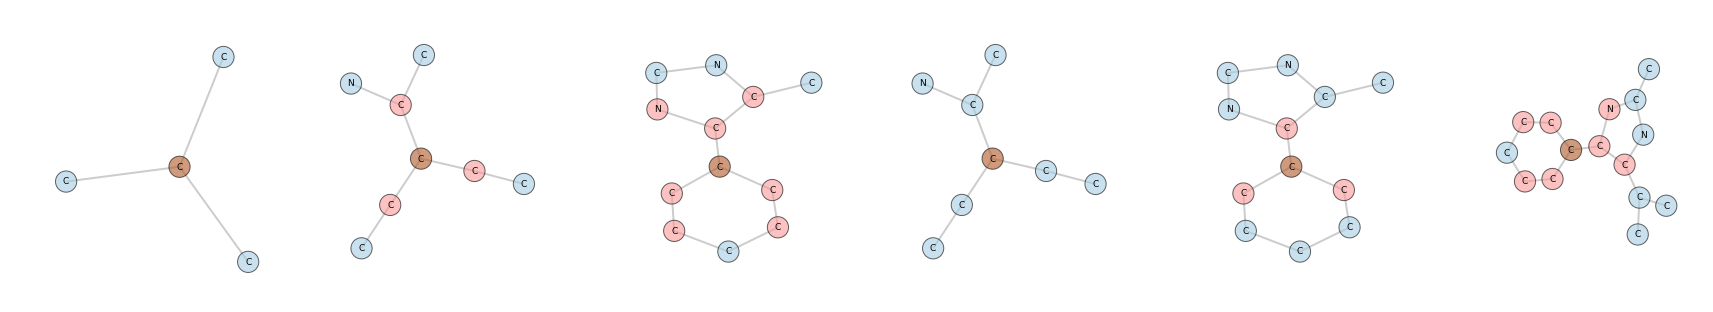

with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up


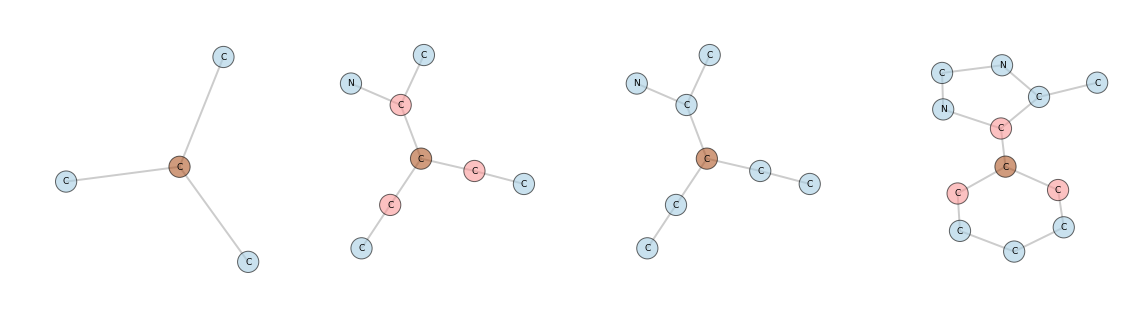

In [25]:
'''
Demonstrating the filter function
'''
#get a graph
graphs = get_graphs(size=1)
graph=graphs.next()
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','O','N','P','Cl','Br','S'])    
graph=graphs.next()
print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)

from graphlearn.utils.draw import cip_to_graph, draw_graph_set_graphlearn
def mark_and_draw(cip):
    graph=cip_to_graph(cip)
    draw_graph_set_graphlearn(graph, n_graphs_per_line=7, size=5,
                              colormap='Paired', invert_colormap=False,node_border=1,
                              vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
radius_list=[0,1,2]
thickness_list=[1,2]
graph.node[1]['no_root']=True
#lets see.. without filter:
from graphlearn.graphtools import extract_core_and_interface
cip=extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'no filter'
mark_and_draw(cip)


# lets do the same but with the filter
cip=extract_core_and_interface(1,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter: nothing should appear,,,'
mark_and_draw(cip)

# filter is ignoring unfiltered things:
cip=extract_core_and_interface(2,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but we chose node 2 as root'
mark_and_draw(cip)

# no core attribute
graph.node[1]["not_in_core"]=True
graph.node[1].pop('no_root')
cip=extract_core_and_interface(2,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up'
mark_and_draw(cip)